___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-3 (RNN)<br><br>Product Amount Forecast by Time<br><h1>

# Dataset Info

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.
**************************
## Veriseti Bilgileri

Bu veri seti hakkında bilgi: https://fred.stlouisfed.org/series/IPN31152N


Birimler: Endeks 2012=100, Mevsimsellikten Arındırılmamış

Sıklık: Aylık

Sanayi üretimi (IP) endeksi, mülkiyetlerine bakılmaksızın Amerika Birleşik Devletleri'nde yerleşik tüm ilgili kuruluşların gerçek çıktısını ölçer, ancak ABD topraklarında bulunanları değil.

NAICS = 31152

Kaynak Kodu: IP.N31152.N

Önerilen Atıf:
Federal Rezerv Sistemi (ABD) Guvernörler Kurulu, Endüstriyel Üretim: Dayanıksız Mallar: Dondurma ve dondurulmuş tatlı [IPN31152N], FRED'den alındı, St. Louis Federal Rezerv Bankası; https://fred.stlouisfed.org/series/IPN31152N, 16 Kasım 2019.

# 1. Libraries|User Defined Functions

## 1.1. Import Libraries

In [1]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

## 1.2. Some Useful User Defined Functions

In [2]:
## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop realted columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
    
###############################################################################

# 2. Read dataset

In [3]:
df0 = pd.read_csv("Frozen_Dessert_Production.csv",
                   index_col='DATE',
                   parse_dates=True)
df = df0.copy()
df.head()
first_looking(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)
# df.head()
# df.describe().T
# df.describe(include=object).T

Shape:(573, 1)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB
None
-------------------------------------------------------------------------------
Number of Uniques:
IPN31152N    573
dtype: int64
-------------------------------------------------------------------------------
Missing Values:
Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []
-------------------------------------------------------------------------------
All Columns:['IPN31152N']
-------------------------------------------------------------------------------
Columns after rename:['ipn31152n']
-------------------------------------------------------------------------------
Duplicate check

In [4]:
df = df.rename(columns={'ipn31152n':'amount'})

In [5]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [6]:
df.tail()

,amount
DATE,
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263
2019-08-01,102.609
2019-09-01,101.587


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,573.000,109.896,27.951,58.660,88.936,107.643,128.278,196.174


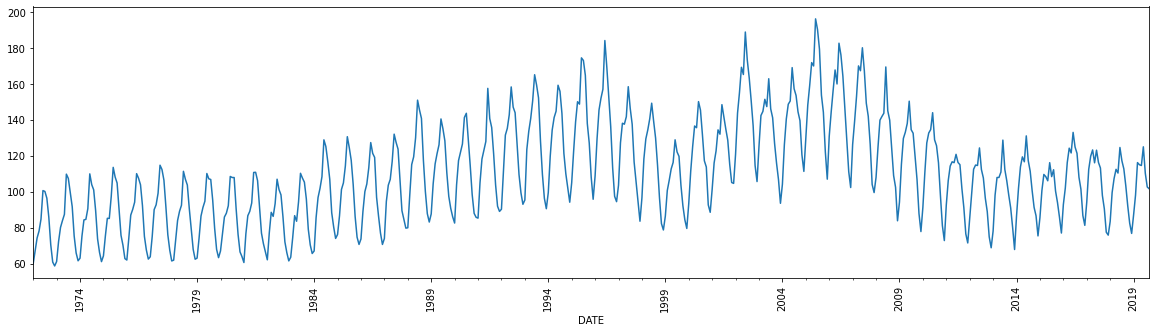

In [8]:
df['amount'].plot(figsize=(20,5))
plt.xticks(rotation=90);

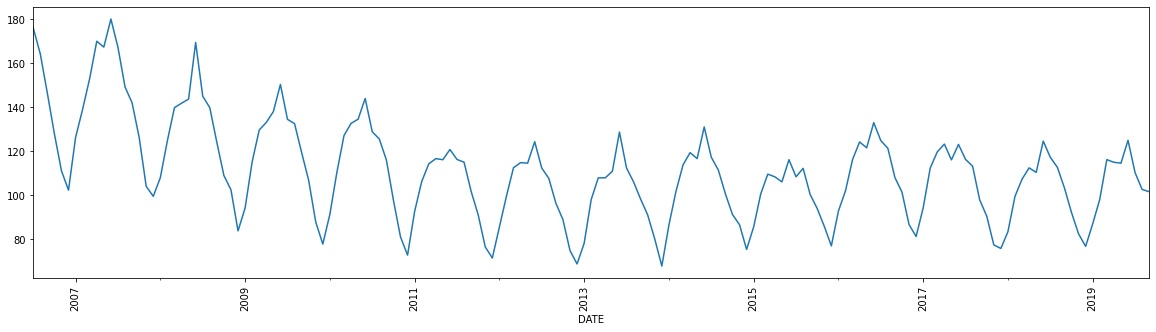

In [9]:
df['amount'].loc["2006-06-30" : "2019-09-01"].plot(figsize=(20,5))
plt.xticks(rotation=90);

### 3. Check missing values

In [10]:
missing_values(df)

,Missing_Number,Missing_Percent


### 4. Plot the distribution of various discrete features on (Season, haliday, weekend and weathercode)

In [11]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [12]:
df_ = df.copy()
df_["year"] = df_.index.year
df_['month'] = df_.index.month 
df_.head()

,amount,year,month
DATE,,,
1972-01-01,59.962,1972,1
1972-02-01,67.061,1972,2
1972-03-01,74.235,1972,3
1972-04-01,78.112,1972,4
1972-05-01,84.764,1972,5


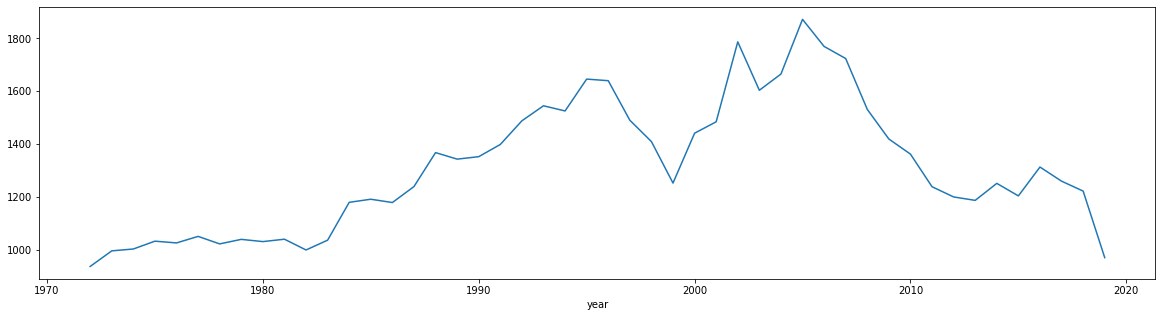

In [13]:
yearly_total_amount = df_.groupby("year")["amount"].sum()
plt.figure(figsize=(20,5))
sns.lineplot(yearly_total_amount.index, yearly_total_amount.values);

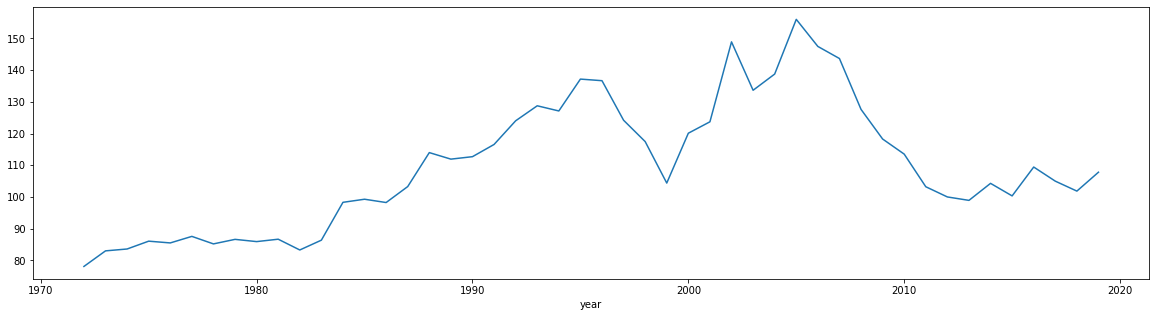

In [14]:
yearly_avg_amount = df_.groupby("year")["amount"].mean()
plt.figure(figsize=(20,5))
sns.lineplot(yearly_avg_amount.index, yearly_avg_amount.values);

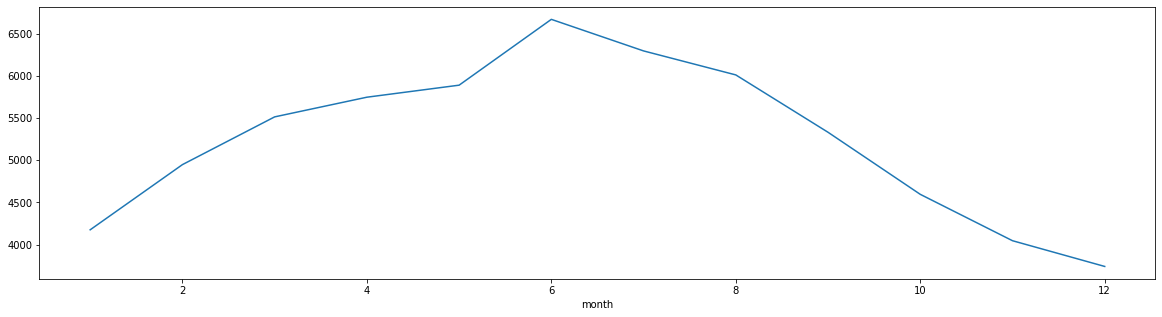

In [15]:
monthly_total_amount = df_.groupby("month")["amount"].sum()
plt.figure(figsize=(20,5))
sns.lineplot(monthly_total_amount.index, monthly_total_amount.values);

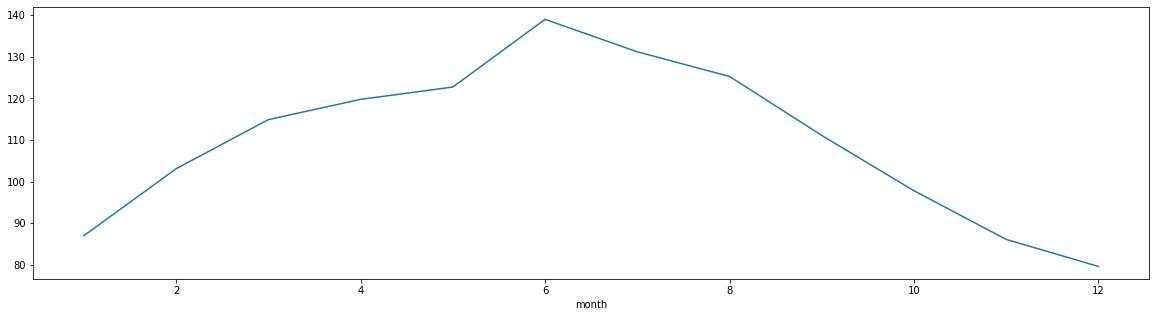

In [16]:
monthly_avg_amount = df_.groupby("month")["amount"].mean()
plt.figure(figsize=(20,5))
sns.lineplot(monthly_avg_amount.index, monthly_avg_amount.values);

### 5. Preprocessing of Data

### Train Test Split

In [22]:
len(df)

573

In [23]:
test_size = int(len(df)*0.10)

In [24]:
test_ind = len(df)- test_size
test_ind 

516

In [25]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [26]:
train.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [27]:
test.head()

,amount
DATE,
2015-01-01,85.577
2015-02-01,100.558
2015-03-01,109.579
2015-04-01,108.362
2015-05-01,106.058


### Scaling

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
scaler = StandardScaler()

In [30]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

### Time Series Generator

In [31]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [32]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [33]:
generator[0]

(array([[[-1.74354122],
         [-1.4984899 ],
         [-1.25080797],
         [-1.11696409],
         [-0.88733399],
         [-0.3407594 ],
         [-0.35697463],
         [-0.48697269],
         [-0.85153067],
         [-1.38342974],
         [-1.71436968],
         [-1.78850337]]]),
 array([[-1.70427529]]))

In [34]:
train_scaled[0:13]

array([[-1.74354122],
       [-1.4984899 ],
       [-1.25080797],
       [-1.11696409],
       [-0.88733399],
       [-0.3407594 ],
       [-0.35697463],
       [-0.48697269],
       [-0.85153067],
       [-1.38342974],
       [-1.71436968],
       [-1.78850337],
       [-1.70427529]])

In [35]:
X, y = generator[0]

In [36]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-1.74354122 -1.4984899  -1.25080797 -1.11696409 -0.88733399 -0.3407594
 -0.35697463 -0.48697269 -0.85153067 -1.38342974 -1.71436968 -1.78850337]
Predict this y: 
 [[-1.70427529]]


## 6. Modelling & Model Performance

### Creating Model

### 6.1. With "tanh" activation function

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout

In [38]:
n_features = 1

In [39]:
model = Sequential()
model.add(LSTM(54, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(36, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 54)                12096     
                                                                 
 dense (Dense)               (None, 36)                1980      
                                                                 
 dense_1 (Dense)             (None, 1)                 37        
                                                                 
Total params: 14,113
Trainable params: 14,113
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [43]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [44]:
len(validation_generator)

45

In [45]:
model.fit_generator(generator, epochs = 64,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/64
504/504 [==============================] - 4s 5ms/step - loss: 0.2154 - val_loss: 0.0524
Epoch 2/64
504/504 [==============================] - 2s 5ms/step - loss: 0.0698 - val_loss: 0.0446
Epoch 3/64
504/504 [==============================] - 2s 5ms/step - loss: 0.0696 - val_loss: 0.0494
Epoch 4/64
504/504 [==============================] - 2s 5ms/step - loss: 0.0685 - val_loss: 0.0530
Epoch 5/64
504/504 [==============================] - 2s 5ms/step - loss: 0.0655 - val_loss: 0.0441
Epoch 6/64
504/504 [==============================] - 2s 5ms/step - loss: 0.0642 - val_loss: 0.0465
Epoch 7/64
504/504 [==============================] - 2s 5ms/step - loss: 0.0649 - val_loss: 0.0439
Epoch 8/64
504/504 [==============================] - 2s 5ms/step - loss: 0.0646 - val_loss: 0.0472
Epoch 9/64
504/504 [==============================] - 2s 5ms/step - loss: 0.0599 - val_loss: 0.0442
Epoch 10/64
504/504 [==============================] - 2s 5ms/step - loss: 0.0601 - val_loss: 0.0428

<AxesSubplot:>

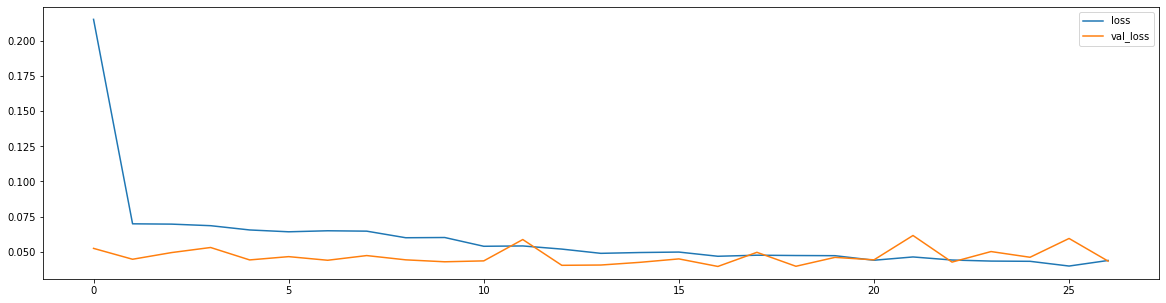

In [46]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(20,5))

#### Evaluate on Test Data

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [48]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [49]:
validation_generator[0]

(array([[[-0.85925682],
         [-0.34207125],
         [-0.03064691],
         [-0.07266774],
         [-0.15220766],
         [ 0.1957795 ],
         [-0.07211883],
         [ 0.06001963],
         [-0.34931063],
         [-0.57082793],
         [-0.8493454 ],
         [-1.15621967]]]),
 array([[-0.6095346]]))

In [50]:
len(validation_generator)

45

In [51]:
validation_generator[40]

(array([[[-0.00387468],
         [ 0.48737065],
         [ 0.23319503],
         [ 0.07633843],
         [-0.24700309],
         [-0.63295469],
         [-0.96773353],
         [-1.16361095],
         [-0.81016922],
         [-0.42652718],
         [ 0.19695672],
         [ 0.15547789]]]),
 array([[0.14135818]]))

In [52]:
y_pred = model.predict(validation_generator)
y_pred

45/45 [==============================] - 0s 2ms/step


array([[-0.87216437],
       [-0.20377243],
       [ 0.00941866],
       [ 0.3773185 ],
       [ 0.6834641 ],
       [ 0.5948134 ],
       [ 0.47305146],
       [ 0.14132372],
       [-0.08604892],
       [-0.48768106],
       [-0.5902912 ],
       [-0.8886957 ],
       [-0.5754936 ],
       [-0.00621025],
       [ 0.4154971 ],
       [ 0.602545  ],
       [ 0.8187069 ],
       [ 0.60195744],
       [ 0.24857304],
       [-0.08936493],
       [-0.24750829],
       [-0.70737773],
       [-0.7475682 ],
       [-0.93493104],
       [-0.59311825],
       [-0.36811882],
       [-0.06405214],
       [ 0.11084263],
       [ 0.38331744],
       [ 0.3534312 ],
       [ 0.25083563],
       [-0.05416324],
       [-0.31853768],
       [-0.6048244 ],
       [-0.8793589 ],
       [-0.9693024 ],
       [-0.8345043 ],
       [-0.30241203],
       [-0.04562645],
       [ 0.33450988],
       [ 0.5282993 ],
       [ 0.48169124],
       [ 0.29778886],
       [-0.23114452],
       [-0.60288525]], dtype=flo

In [53]:
len(y_pred)

45

In [54]:
len(test_scaled)

57

In [55]:
len(test_scaled[12:])

45

In [56]:
test_scaled[12:]

array([[-0.6095346 ],
       [-0.29317698],
       [ 0.19721564],
       [ 0.47447648],
       [ 0.38240143],
       [ 0.77744281],
       [ 0.49659852],
       [ 0.37510336],
       [-0.08391518],
       [-0.31356945],
       [-0.8217032 ],
       [-1.00839417],
       [-0.55999821],
       [ 0.0663269 ],
       [ 0.31869699],
       [ 0.44056154],
       [ 0.19321793],
       [ 0.43568696],
       [ 0.20013625],
       [ 0.09338566],
       [-0.43340062],
       [-0.69022412],
       [-1.14023919],
       [-1.19637283],
       [-0.9332248 ],
       [-0.37894477],
       [-0.10879557],
       [ 0.06781137],
       [-0.00387468],
       [ 0.48737065],
       [ 0.23319503],
       [ 0.07633843],
       [-0.24700309],
       [-0.63295469],
       [-0.96773353],
       [-1.16361095],
       [-0.81016922],
       [-0.42652718],
       [ 0.19695672],
       [ 0.15547789],
       [ 0.14135818],
       [ 0.50036493],
       [-0.00702313],
       [-0.27128279],
       [-0.30656137]])

In [57]:
eval_metrics(test_scaled[12:], y_pred)

r2_score: 0.8408987593517014 
 mae: 0.1608793104072494 
 mse: 0.04328482170158502 
 rmse: 0.20805004614655825


In [58]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 16ms/step


In [59]:
eval_metrics(test_scaled, test_predictions)

r2_score: -1.244658209098223 
 mae: 0.5748516314028286 
 mse: 0.5734204341603837 
 rmse: 0.7572452932573326


#### Inverse Transformations and Comparing

In [60]:
true_predictions = scaler.inverse_transform(test_predictions)

In [61]:
test.head()

,amount
DATE,
2015-01-01,85.577
2015-02-01,100.558
2015-03-01,109.579
2015-04-01,108.362
2015-05-01,106.058


In [62]:
test['prediction'] = true_predictions

In [63]:
test.head()

,amount,prediction
DATE,,
2015-01-01,85.577,86.872
2015-02-01,100.558,103.812
2015-03-01,109.579,113.144
2015-04-01,108.362,119.409
2015-05-01,106.058,128.055


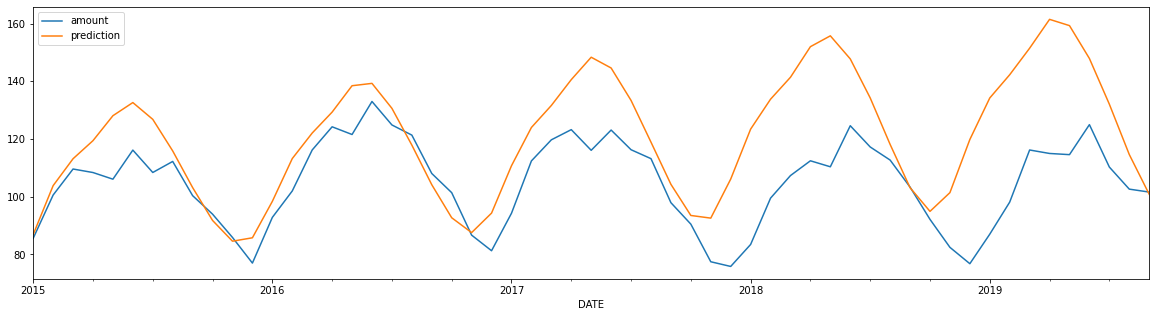

In [64]:
test.plot(figsize=(20,5));

#### Calculation R2 Score and Error Metrics

In [65]:
eval_metrics(test.amount, test.prediction)

r2_score: -1.244658137465927 
 mae: 16.651488887104236 
 mse: 481.13590637938427 
 rmse: 21.934810379380632


### 6.2. With "relu" activation function

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

n_features = 1
model = Sequential()

model.add(LSTM(54, activation = 'relu', input_shape = (length, n_features))) 
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1)) 

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 54)                12096     
                                                                 
 dense_4 (Dense)             (None, 32)                1760      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,889
Trainable params: 13,889
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [68]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)
len(validation_generator)

45

In [69]:
model.fit_generator(generator, epochs = 64,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/64
504/504 [==============================] - 3s 4ms/step - loss: 0.3637 - val_loss: 0.0796
Epoch 2/64
504/504 [==============================] - 2s 3ms/step - loss: 0.0900 - val_loss: 0.0529
Epoch 3/64
504/504 [==============================] - 2s 4ms/step - loss: 0.0759 - val_loss: 0.0479
Epoch 4/64
504/504 [==============================] - 2s 4ms/step - loss: 0.0709 - val_loss: 0.0596
Epoch 5/64
504/504 [==============================] - 2s 4ms/step - loss: 0.0758 - val_loss: 0.0464
Epoch 6/64
504/504 [==============================] - 2s 4ms/step - loss: 0.0706 - val_loss: 0.0478
Epoch 7/64
504/504 [==============================] - 2s 4ms/step - loss: 0.0624 - val_loss: 0.0672
Epoch 8/64
504/504 [==============================] - 2s 4ms/step - loss: 0.0643 - val_loss: 0.0466
Epoch 9/64
504/504 [==============================] - 2s 4ms/step - loss: 0.0659 - val_loss: 0.0501
Epoch 10/64
504/504 [==============================] - 2s 4ms/step - loss: 0.0561 - val_loss: 0.0518

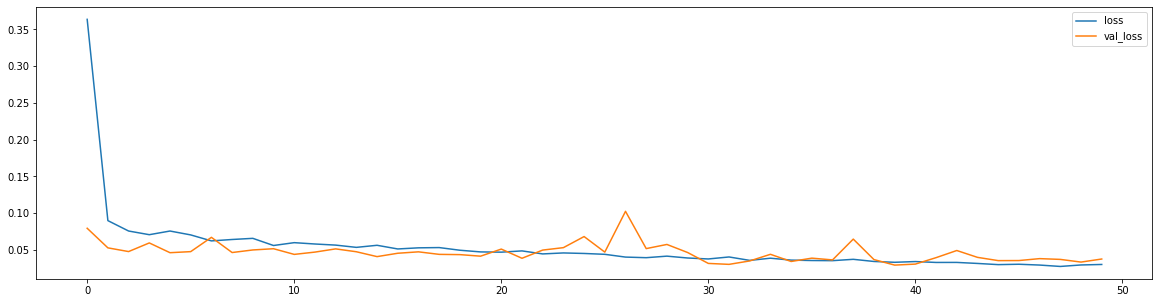

In [70]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(20,5));

In [71]:
df

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
1972-06-01,100.596
1972-07-01,100.126
1972-08-01,96.361
1972-09-01,85.801


#### Evaluate on Test Data

In [72]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [73]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [74]:
y_pred = model.predict(validation_generator)
y_pred

45/45 [==============================] - 0s 2ms/step


array([[-0.8581896 ],
       [-0.00865244],
       [ 0.19968578],
       [ 0.4921469 ],
       [ 0.7249756 ],
       [ 0.8933587 ],
       [ 0.5539954 ],
       [ 0.1755228 ],
       [-0.09300398],
       [-0.55128074],
       [-0.7346711 ],
       [-1.0838549 ],
       [-0.61332464],
       [ 0.05709714],
       [ 0.5459777 ],
       [ 0.6476852 ],
       [ 0.70792115],
       [ 0.548726  ],
       [ 0.25453448],
       [-0.02964588],
       [-0.26792306],
       [-0.7349852 ],
       [-0.9088171 ],
       [-1.0960693 ],
       [-0.59948426],
       [-0.24895364],
       [ 0.03073839],
       [ 0.1471048 ],
       [ 0.33278507],
       [ 0.47129124],
       [ 0.25315028],
       [-0.05386075],
       [-0.3765657 ],
       [-0.6998922 ],
       [-1.0228381 ],
       [-1.1684337 ],
       [-0.8820893 ],
       [-0.23030213],
       [ 0.04934179],
       [ 0.45447493],
       [ 0.47907478],
       [ 0.64696956],
       [ 0.35803384],
       [-0.19594926],
       [-0.602479  ]], dtype=flo

In [75]:
test_scaled[12:]

array([[-0.6095346 ],
       [-0.29317698],
       [ 0.19721564],
       [ 0.47447648],
       [ 0.38240143],
       [ 0.77744281],
       [ 0.49659852],
       [ 0.37510336],
       [-0.08391518],
       [-0.31356945],
       [-0.8217032 ],
       [-1.00839417],
       [-0.55999821],
       [ 0.0663269 ],
       [ 0.31869699],
       [ 0.44056154],
       [ 0.19321793],
       [ 0.43568696],
       [ 0.20013625],
       [ 0.09338566],
       [-0.43340062],
       [-0.69022412],
       [-1.14023919],
       [-1.19637283],
       [-0.9332248 ],
       [-0.37894477],
       [-0.10879557],
       [ 0.06781137],
       [-0.00387468],
       [ 0.48737065],
       [ 0.23319503],
       [ 0.07633843],
       [-0.24700309],
       [-0.63295469],
       [-0.96773353],
       [-1.16361095],
       [-0.81016922],
       [-0.42652718],
       [ 0.19695672],
       [ 0.15547789],
       [ 0.14135818],
       [ 0.50036493],
       [-0.00702313],
       [-0.27128279],
       [-0.30656137]])

In [76]:
eval_metrics(test_scaled[12:], y_pred)

r2_score: 0.8611902424186689 
 mae: 0.15332097482983992 
 mse: 0.037764354211605 
 rmse: 0.19433052825432498


In [77]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 16ms/step


In [79]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.23784396294264354 
 mae: 0.3471308780523011 
 mse: 0.19470039754647683 
 rmse: 0.44124867993737593


#### Inverse Transformations and Comparing

In [80]:
true_predictions_relu = scaler.inverse_transform(test_predictions)

In [81]:
test['predictions_relu'] = true_predictions_relu

In [82]:
test.head()

,amount,prediction,predictions_relu
DATE,,,
2015-01-01,85.577,86.872,84.015
2015-02-01,100.558,103.812,103.656
2015-03-01,109.579,113.144,116.976
2015-04-01,108.362,119.409,124.488
2015-05-01,106.058,128.055,130.585


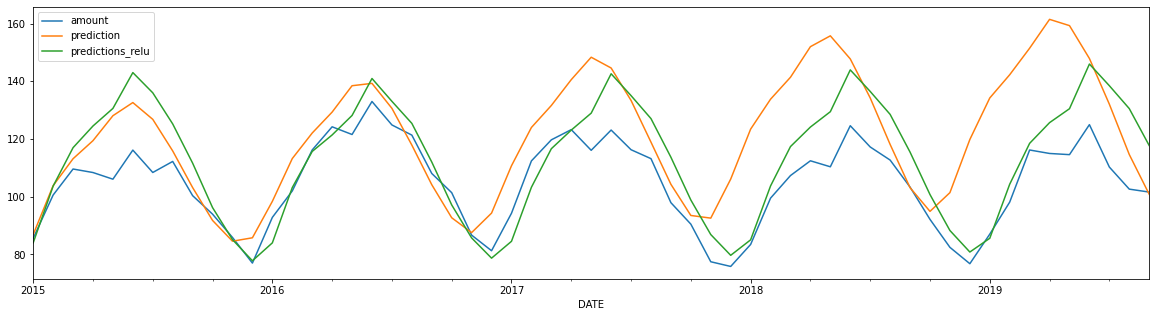

In [83]:
test.plot(figsize=(20,5));

#### Calculation R2 Score and Error Metrics

In [84]:
eval_metrics(test.amount, test.predictions_relu)

r2_score: 0.23784391323665144 
 mae: 10.055196577319764 
 mse: 163.3659279721898 
 rmse: 12.781468146194701


## 7. Retrain and Forecasting

In [85]:
test

,amount,prediction,predictions_relu
DATE,,,
2015-01-01,85.577,86.872,84.015
2015-02-01,100.558,103.812,103.656
2015-03-01,109.579,113.144,116.976
2015-04-01,108.362,119.409,124.488
2015-05-01,106.058,128.055,130.585
2015-06-01,116.138,132.611,142.999
2015-07-01,108.378,126.796,135.988
2015-08-01,112.205,115.847,125.208
2015-09-01,100.348,103.151,111.615


In [86]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [87]:
length = 12 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [88]:
model = Sequential()

model.add(LSTM(54, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(24, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=64)

Epoch 1/64
561/561 [==============================] - 4s 4ms/step - loss: 0.2355
Epoch 2/64
561/561 [==============================] - 2s 4ms/step - loss: 0.0698
Epoch 3/64
561/561 [==============================] - 2s 4ms/step - loss: 0.0679
Epoch 4/64
561/561 [==============================] - 3s 4ms/step - loss: 0.0674
Epoch 5/64
561/561 [==============================] - 3s 5ms/step - loss: 0.0687
Epoch 6/64
561/561 [==============================] - 2s 4ms/step - loss: 0.0636
Epoch 7/64
561/561 [==============================] - 2s 4ms/step - loss: 0.0626
Epoch 8/64
561/561 [==============================] - 2s 4ms/step - loss: 0.0578
Epoch 9/64
561/561 [==============================] - 2s 4ms/step - loss: 0.0554
Epoch 10/64
561/561 [==============================] - 2s 4ms/step - loss: 0.0583
Epoch 11/64
561/561 [==============================] - 2s 4ms/step - loss: 0.0545
Epoch 12/64
561/561 [==============================] - 2s 4ms/step - loss: 0.0523
Epoch 13/64
561/561 [====

In [89]:
scaled_full_data.shape

(573, 1)

In [90]:
scaled_full_data[-length:].shape

(12, 1)

In [91]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:] 
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 15ms/step


In [92]:
forecast = scaler.inverse_transform(forecast)

In [93]:
forecast

array([[ 90.34834 ],
       [ 79.89154 ],
       [ 75.273766],
       [ 87.20669 ],
       [102.51212 ],
       [111.653885],
       [115.62789 ],
       [113.695786],
       [123.72194 ],
       [114.07641 ],
       [107.18256 ],
       [ 95.27498 ],
       [ 84.65422 ],
       [ 76.1547  ],
       [ 73.221436],
       [ 87.51968 ],
       [102.77935 ],
       [109.3376  ],
       [113.85767 ],
       [118.318565],
       [119.51944 ],
       [114.44481 ],
       [103.91537 ],
       [ 91.22686 ]], dtype=float32)

In [94]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [95]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [96]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [97]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['forecast'])

In [98]:
forecast_df

,forecast
2019-10-01,90.348
2019-11-01,79.892
2019-12-01,75.274
2020-01-01,87.207
2020-02-01,102.512
2020-03-01,111.654
2020-04-01,115.628
2020-05-01,113.696
2020-06-01,123.722
2020-07-01,114.076


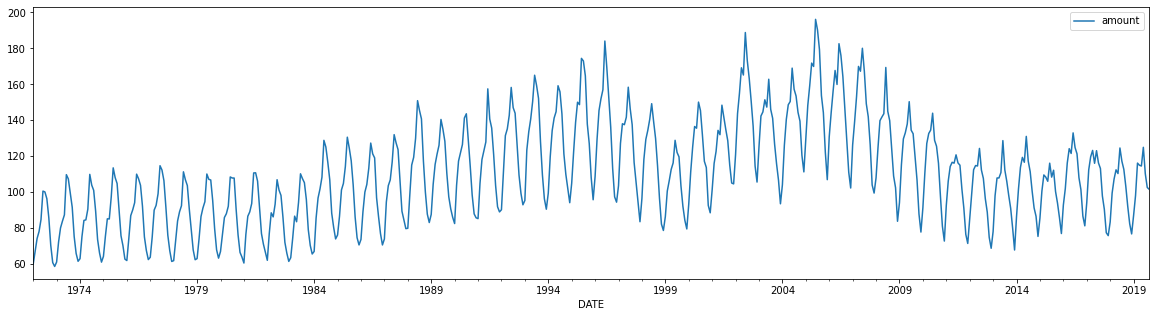

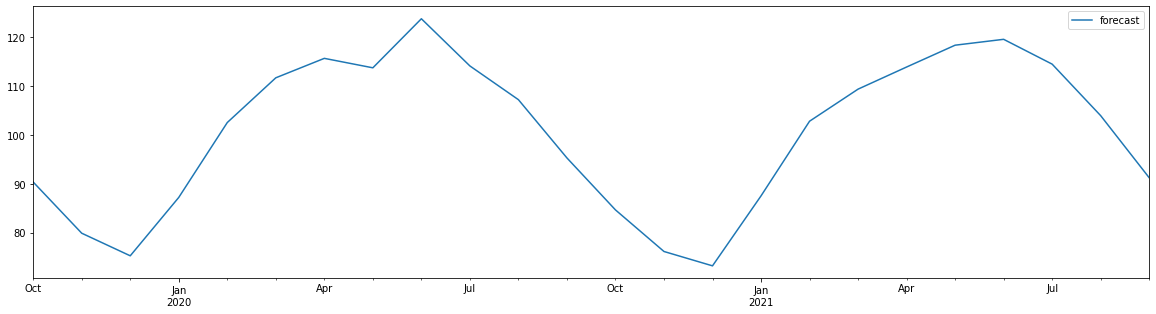

In [100]:
df.plot(figsize=(20,5));
forecast_df.plot(figsize=(20,5));

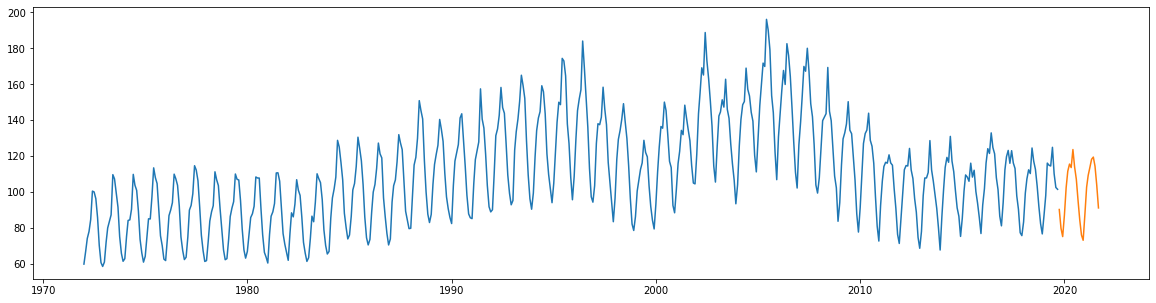

In [101]:
plt.figure(figsize = (20, 5))
plt.plot(df.index, df['amount'])
plt.plot(forecast_df.index, forecast_df['forecast']);
#plt.plot(forecast_index, forecast)

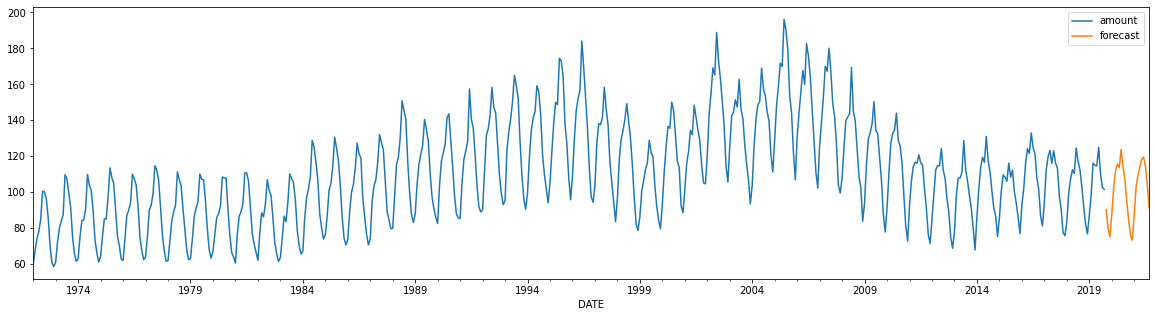

In [102]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (20, 5));

## Appx. Another approach: With actual human consuming behaviours in last 10 years

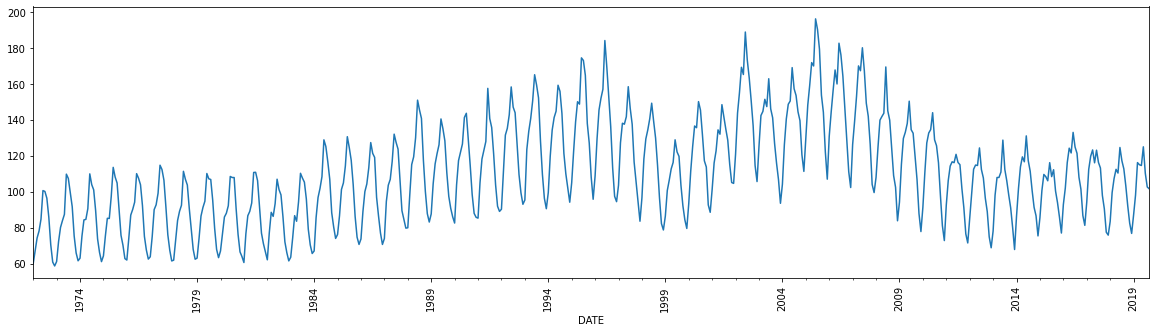

In [103]:
df['amount'].plot(figsize=(20,5))
plt.xticks(rotation=90);

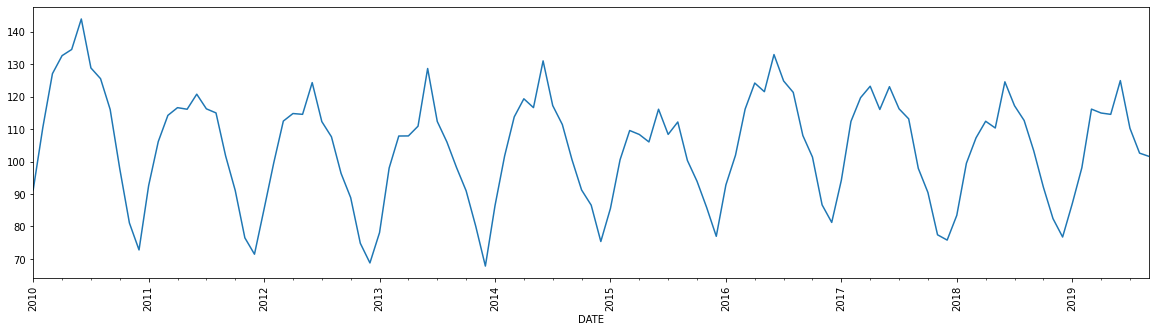

In [104]:
df['amount'].loc["2010-01-01" : "2019-09-01"].plot(figsize=(20,5))
plt.xticks(rotation=90);

In [105]:
df = df.loc["2010-01-01" : "2019-09-01"]
df.head()

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558


### Preprocessing of Data

### Train Test Split

In [106]:
len(df)

117

In [107]:
test_size = 36

In [108]:
test_ind = len(df)- test_size
test_ind

81

In [109]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [110]:
train.head()

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558


In [111]:
test.head()

,amount
DATE,
2016-10-01,101.384
2016-11-01,86.665
2016-12-01,81.257
2017-01-01,94.245
2017-02-01,112.388


### Scaling

In [112]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [113]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [114]:
# help(TimeseriesGenerator)

In [115]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [116]:
generator[0]

(array([[[-0.77649658],
         [ 0.32921347],
         [ 1.28456688],
         [ 1.60400421],
         [ 1.71398868],
         [ 2.25471882],
         [ 1.38584262],
         [ 1.19587938],
         [ 0.6497732 ],
         [-0.40451905],
         [-1.36374046],
         [-1.84188628]]]),
 array([[-0.70043185]]))

In [117]:
train_scaled[0:13]

array([[-0.77649658],
       [ 0.32921347],
       [ 1.28456688],
       [ 1.60400421],
       [ 1.71398868],
       [ 2.25471882],
       [ 1.38584262],
       [ 1.19587938],
       [ 0.6497732 ],
       [-0.40451905],
       [-1.36374046],
       [-1.84188628],
       [-0.70043185]])

In [118]:
X_act, y_act= generator[0]

In [119]:
print(f'Given the Array: \n{X_act.flatten()}')
print(f'Predict this y: \n {y_act}')

Given the Array: 
[-0.77649658  0.32921347  1.28456688  1.60400421  1.71398868  2.25471882
  1.38584262  1.19587938  0.6497732  -0.40451905 -1.36374046 -1.84188628]
Predict this y: 
 [[-0.70043185]]


## Modelling & Model Performance

### Creating Model

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
n_features = 1
model = Sequential()
model.add(LSTM(54, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(24, activation = 'tanh'))
model.add(Dense(1)) 
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 54)                12096     
                                                                 
 dense_8 (Dense)             (None, 24)                1320      
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 13,441
Trainable params: 13,441
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [121]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)
model.fit_generator(generator, epochs = 64,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/64
69/69 [==============================] - 2s 10ms/step - loss: 0.5831 - val_loss: 0.1650
Epoch 2/64
69/69 [==============================] - 0s 5ms/step - loss: 0.1791 - val_loss: 0.0855
Epoch 3/64
69/69 [==============================] - 0s 5ms/step - loss: 0.1297 - val_loss: 0.1144
Epoch 4/64
69/69 [==============================] - 0s 5ms/step - loss: 0.1017 - val_loss: 0.0805
Epoch 5/64
69/69 [==============================] - 0s 5ms/step - loss: 0.0971 - val_loss: 0.1002
Epoch 6/64
69/69 [==============================] - 0s 5ms/step - loss: 0.1010 - val_loss: 0.1168
Epoch 7/64
69/69 [==============================] - 0s 5ms/step - loss: 0.0991 - val_loss: 0.0879
Epoch 8/64
69/69 [==============================] - 0s 5ms/step - loss: 0.0988 - val_loss: 0.0824
Epoch 9/64
69/69 [==============================] - 0s 5ms/step - loss: 0.0864 - val_loss: 0.1138
Epoch 10/64
69/69 [==============================] - 0s 5ms/step - loss: 0.0967 - val_loss: 0.0820
Epoch 11/64
69/69 

<AxesSubplot:>

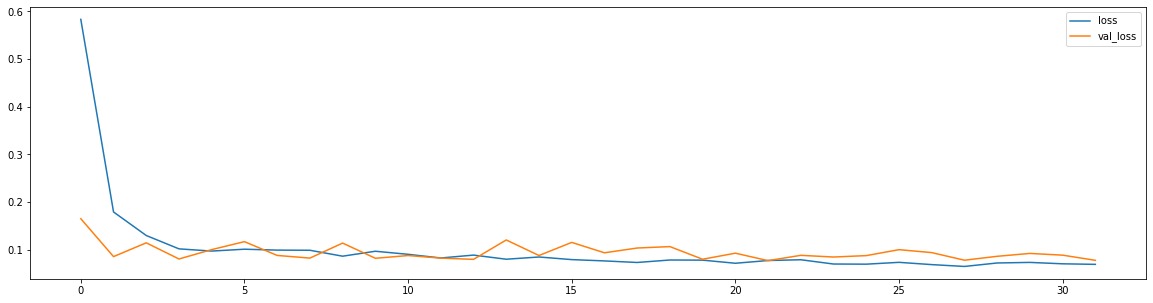

In [122]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(20,5))

#### Evaluate on Test Data

In [123]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)
y_pred = model.predict(validation_generator)
eval_metrics(test_scaled[12:], y_pred)

24/24 [==============================] - 0s 2ms/step
r2_score: 0.8940623457912187 
 mae: 0.2137451932712012 
 mse: 0.07767798469397781 
 rmse: 0.2787077047624945


In [124]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
eval_metrics(test_scaled, test_predictions)

1/1 [==============================] - 0s 15ms/step
r2_score: 0.7771523035314204 
 mae: 0.3303650156854988 
 mse: 0.16067926027933244 
 rmse: 0.4008481760958037


#### Inverse Transformations and Comparing

In [125]:
true_predictions = scaler.inverse_transform(test_predictions)

In [126]:
test.head()

,amount
DATE,
2016-10-01,101.384
2016-11-01,86.665
2016-12-01,81.257
2017-01-01,94.245
2017-02-01,112.388


In [127]:
test['prediction'] = true_predictions

In [128]:
test

,amount,prediction
DATE,,
2016-10-01,101.384,99.650
2016-11-01,86.665,86.544
2016-12-01,81.257,78.090
2017-01-01,94.245,88.475
2017-02-01,112.388,99.883
2017-03-01,119.698,107.446
2017-04-01,123.228,111.330
2017-05-01,116.064,113.402
2017-06-01,123.087,114.946


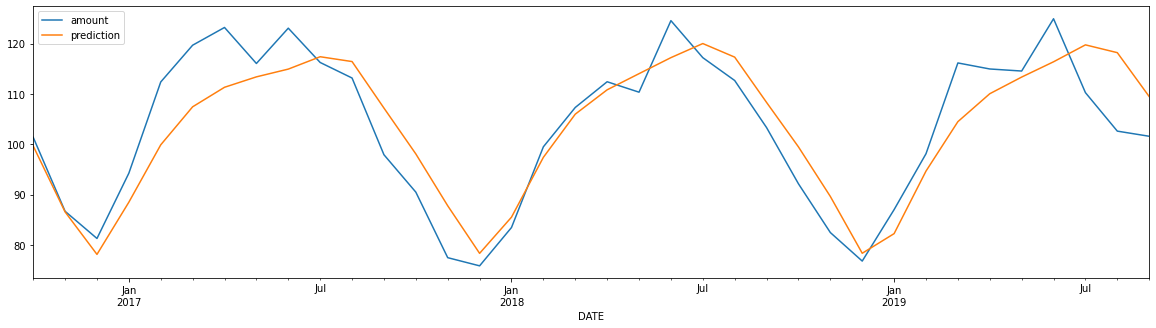

In [129]:
test.plot(figsize=(20,5));

#### Calculation R2 Score and Error Metrics

In [130]:
eval_metrics(test.amount, test.prediction)

r2_score: 0.777152302980838 
 mae: 5.739550553046332 
 mse: 48.498412365763336 
 rmse: 6.964080152163912


## Retrain and Forecasting

In [131]:
test

,amount,prediction
DATE,,
2016-10-01,101.384,99.650
2016-11-01,86.665,86.544
2016-12-01,81.257,78.090
2017-01-01,94.245,88.475
2017-02-01,112.388,99.883
2017-03-01,119.698,107.446
2017-04-01,123.228,111.330
2017-05-01,116.064,113.402
2017-06-01,123.087,114.946


In [132]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [133]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [134]:
model = Sequential()

model.add(LSTM(50, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(25, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=64)

Epoch 1/64
105/105 [==============================] - 2s 4ms/step - loss: 0.5376
Epoch 2/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1530
Epoch 3/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1211
Epoch 4/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1119
Epoch 5/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1164
Epoch 6/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1030
Epoch 7/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1044
Epoch 8/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1131
Epoch 9/64
105/105 [==============================] - 0s 4ms/step - loss: 0.0979
Epoch 10/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1076
Epoch 11/64
105/105 [==============================] - 0s 4ms/step - loss: 0.0966
Epoch 12/64
105/105 [==============================] - 0s 4ms/step - loss: 0.0983
Epoch 13/64
105/105 [====

In [135]:
scaled_full_data.shape

(117, 1)

In [136]:
scaled_full_data[-length:].shape

(12, 1)

In [137]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:] 
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 15ms/step


In [138]:
forecast = scaler.inverse_transform(forecast)

In [139]:
forecast

array([[ 88.89489 ],
       [ 76.41416 ],
       [ 71.39067 ],
       [ 86.198006],
       [103.282974],
       [115.66959 ],
       [116.052345],
       [118.420525],
       [128.5549  ],
       [116.2676  ],
       [109.87552 ],
       [101.22087 ]], dtype=float32)

In [140]:
df.head()

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558


In [141]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [142]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [143]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['forecast'])

In [144]:
forecast_df

,forecast
2019-10-01,88.895
2019-11-01,76.414
2019-12-01,71.391
2020-01-01,86.198
2020-02-01,103.283
2020-03-01,115.670
2020-04-01,116.052
2020-05-01,118.421
2020-06-01,128.555
2020-07-01,116.268


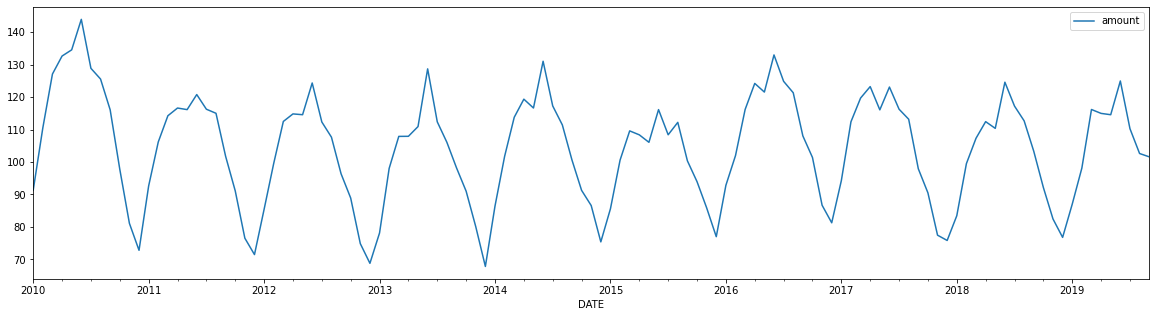

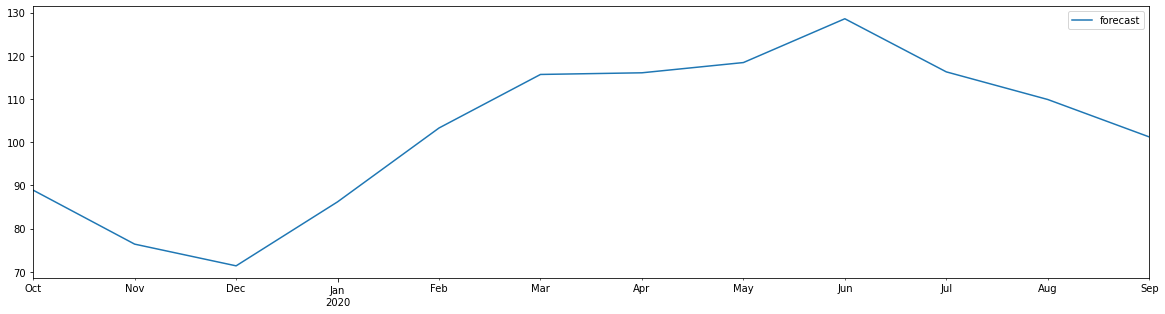

In [145]:
df.plot(figsize=(20,5));
forecast_df.plot(figsize=(20,5));

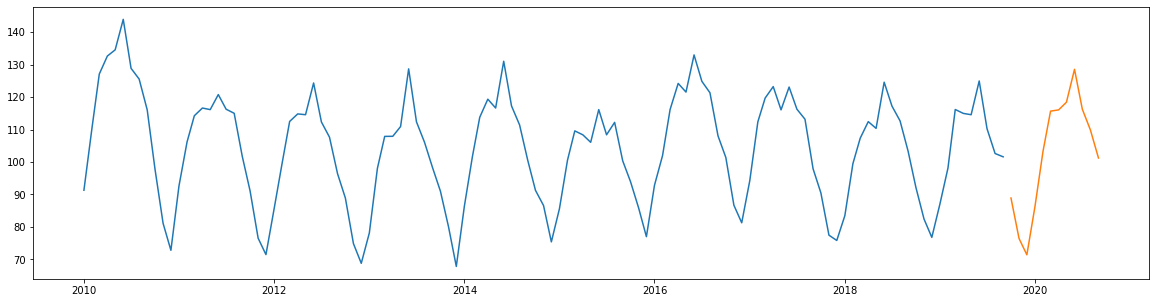

In [146]:
plt.figure(figsize = (20, 5))
plt.plot(df.index, df['amount'])
plt.plot(forecast_df.index, forecast_df['forecast']);
#plt.plot(forecast_index, forecast)

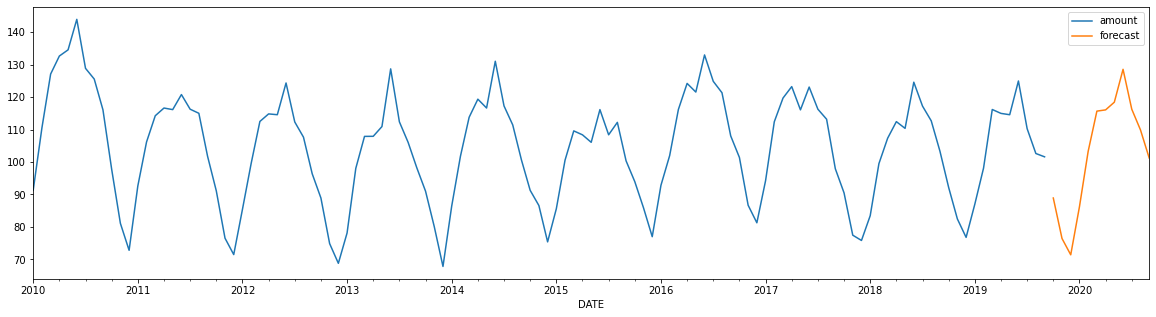

In [147]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (20, 5));

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>